### Base Florance-2 Model

This notebook serves as an intro to Florance 2 base performance and shows some examples of the types of tasks it can acomplish.

Florance-2 is a vision foundation model trained by Microsoft in 2023. It has good out of the box performance at a variety of image tasks. It produces predictions by outputing text tokens, with a limit of 1024 per image. To designate parts of the image, normalised x, y co-ordinates are produced by the model.

This notebook details how to use Florance-2 and its base model. We need to specify both a task type and a specific prompt for further instructions.

Task Types (a sample of the main tasks), input as a prompt:
- `<CAPTION>` Description
- `<DETAILED_CAPTION>` Description
- `<OD>` Object detection
- `<REFERRING_EXPRESSION_SEGMENTATION>` Segmentation, given text
- `<REGION_TO_SEGMENTATION>` Segmentation, given a bounding box
- `<OCR>` Optical Character Recognition
- `<OCR_WITH_REGION>` Optical Character Recognition which also provides a bounding box

We can also add regions by specifying the task with `<loc1><loc2><loc3><loc4>` after the task type above, ie `<TASK><loc1><loc2><loc3><loc4>`.

Alternative:
- VQA: What does the image describe?
- VQA: What does the region `<loc1><loc2><loc3><loc4>` describe?
- Object Detection: Locate objects in the image.
- Object Detection: Locate the phrases in the caption: `<loc1><loc2><loc3><loc4>`.
- Segmentation: What is the polygon mask of region `<loc1><loc2><loc3><loc4>`?
- OCR: Extract text with region `<loc1><loc2><loc3><loc4>`.

Additional reading:
- https://arxiv.org/abs/2311.06242
- https://medium.com/data-science/Florance-2-mastering-multiple-vision-tasks-with-a-single-vlm-model-435d251976d0

#### Setup model and import libraries

In [ ]:
# import libraries
import os
import torch
from transformers import AutoProcessor, AutoModelForCausalLM 

# import custom libraries
from utils.image_functions import read_image, display_image
from utils.Florance_functions import obj_det_Florance

# setup device and dtype if using GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"DEVICE: {device} \nTORCH DTYPE: {torch_dtype}")

# Load model and processor from Hugging Face
# microsoft/Florance-2-large-ft is the fine-tuned version of microsoft/Florance-2-large. It is finetuned for a variety of downstream tasks.
model_name = "microsoft/Florance-2-large-ft" # microsoft/Florance-2-large
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
florance2_setup = [model, processor, device, torch_dtype]

# setup correct file paths
data_path = "./sample_data/"

c:\Users\henrytaylor\OneDrive - Microsoft\Desktop\Current Project\IP\Florance-2 Finetune\f2f\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda:0 
TORCH DTYPE: torch.float16


c:\Users\henrytaylor\OneDrive - Microsoft\Desktop\Current Project\IP\Florance-2 Finetune\f2f\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that i

In [ ]:
from PIL import ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import re

def draw_bounding_boxes(image, combined_results, size_bb = 20, size_text = 20, label_bb = True, color_bb = True):
    """
    Draw bounding box for dictionary of bounding boxes and labels.
    {"bboxes": all_boxes, "labels": all_labels} OR {"polygons": all_boxes, "labels": all_labels}
    size_bb - width of bounding box
    label_bb - add label to image bb
    color_bb - color the bounding box with random different color per class, else red
    """
    # Draw bounding boxes on the image
    modified_image = image.copy()
    draw = ImageDraw.Draw(modified_image)
    font = ImageFont.truetype("arial.ttf", size_text)
    classes = list(np.unique(combined_results['labels']))
    
    bbox_type = "bboxes" if "bboxes" in combined_results else "polygons" # get bbox type from combined_results
    
    cmap_type = 'RdYlBu'
    if color_bb:
        colors = plt.get_cmap(cmap_type, len(classes))
    for box, label in zip(combined_results[bbox_type], combined_results["labels"]):
        if color_bb:
            class_index = classes.index(label)
            color = tuple(int(c * 255) for c in colors(class_index)[:3])
        else:
            color = "red"
        
        x1, y1 = box[0], box[1]
        if bbox_type == "bboxes":
            draw.rectangle(box, outline=color, width=size_bb)
        elif bbox_type == "polygons": # quad_boxes - number of points: x1, y1, x2, y2, ...., xi, yi
            draw.polygon(box, outline=color, fill=color, width=size_bb)
        if label_bb:
            draw.text((x1+5, y1+5), label, fill="black", font=font)
            
    fig, ax = plt.subplots(1)
    ax.imshow(modified_image)
    plt.axis('off')
    plt.show()
    
def inference_Florance(image, task_input, text_inputs:list=[], florance2_setup:list=None):
    """
    Perform a variety of tasks for Florance-2 model. 
    Prompts take priority over task_input and text_inputs.
    If no prompts are given, we can use the default task_input with suplimentatry text inputs.
    Text inputs are used to add more context to the task_input, such as bounding boxes.
    """
    # we can combine as so: 
    # prompts = "detect cars and motobikes in the image"
    # but if it cannot detect the object, it may be because of model's limitations in handling complex scenes with multiple objects. 
    # Therefore, its better to call one at a time to get the bounding boxes for each class
    model, processor, device, torch_dtype = florance2_setup
    
    if len(text_inputs)>0: 
        prompts = [task_input + text_input for text_input in text_inputs]
    else:
        prompts = [task_input]
    print(f"Prompts: {prompts}")
    
    model_response = []
    for prompt in prompts:
        # Process the input
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, dtype=torch_dtype)

        # Generate predictions
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024, # limit
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )

        # Decode the predictions
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        # print(generated_text)

        # Post-process the output
        parsed_answer = processor.post_process_generation(generated_text, task=task_input, image_size=(image.width, image.height))
        
        # Collect results
        model_response.append(parsed_answer)
    
    return model_response

#### Caption
Describe an image

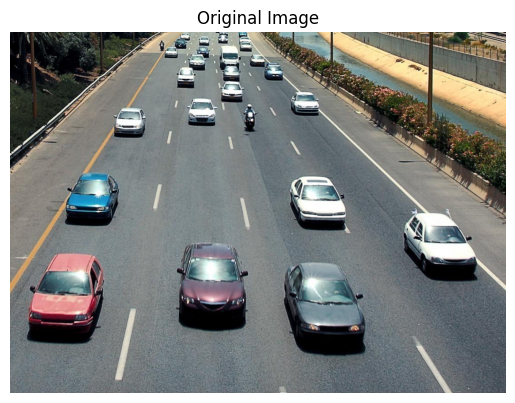

Prompts: ['<CAPTION>']
['A highway filled with lots of traffic next to a river.'] 

Prompts: ['<MORE_DETAILED_CAPTION>']
['There are several cars driving on the street. There is a blue car in the middle of the street and a red car in front of it. There are white lines on the road. '] 

Prompts: ['<REGION_TO_CATEGORY><loc_200><loc_200><loc_290><loc_300>']


AttributeError: 'list' object has no attribute 'split'

In [ ]:
# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

# <CAPTION> <DETAILED_CAPTION> <MORE_DETAILED_CAPTION>
task_input = "<CAPTION>"
text_inputs = []
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup) 
combined_results = [result[task_input] for result in results]
print(combined_results, "\n")

task_input = "<MORE_DETAILED_CAPTION>"
text_inputs = []
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup) 
combined_results = [result[task_input] for result in results]
print(combined_results, "\n")

# provided bbox coordinates correlate to a car in top left of image. Lets see if Florance-2 can detect and classify it.
task_input = "<REGION_TO_CATEGORY>" # <REGION_TO_DESCRIPTION>
text_inputs = ["<loc_200><loc_200><loc_290><loc_300>"] # Normalised x1, x2, y1, y2 for florance-2 model. Range is [001, 999]
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup) 
combined_results = [result[task_input] for result in results]
print(combined_results.split("<"[0]))

#### Object Detection
Find objects in an image

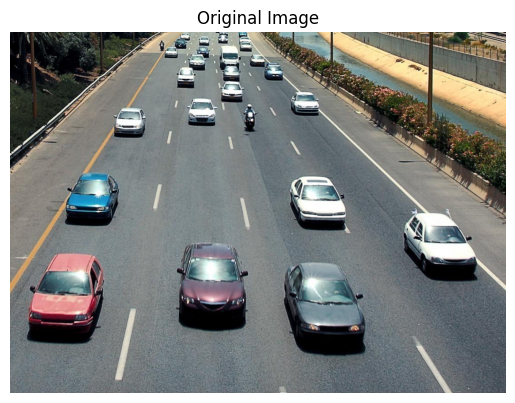

Prompts: ['<OD>']


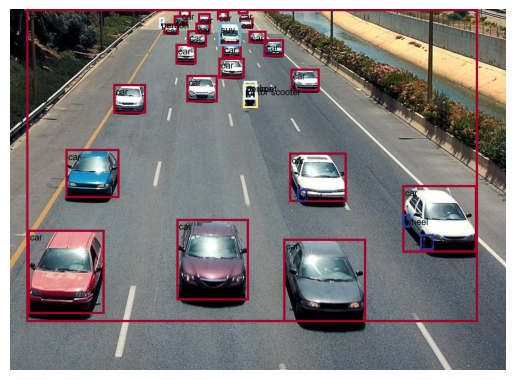

Prompts: ['<OPEN_VOCABULARY_DETECTION>car', '<OPEN_VOCABULARY_DETECTION>van']


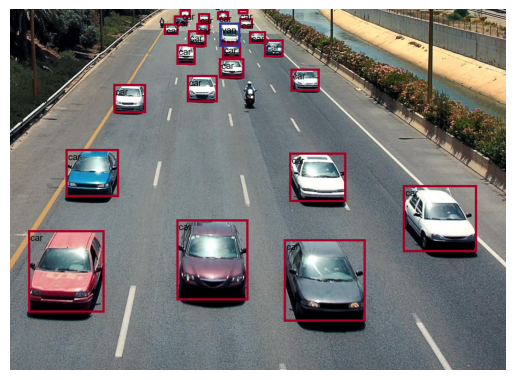

In [ ]:
# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

# no classes/ prompts specified
task_input = "<OD>"
text_inputs = []
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)  # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5) # draw bounding boxes on image

# three classes/ prompts - better performance with enhanced prompt
task_input = "<OPEN_VOCABULARY_DETECTION>"
text_inputs = ["car", "van"]
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["bboxes_labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5)

### Optical Character Recognition
Extract text from an image

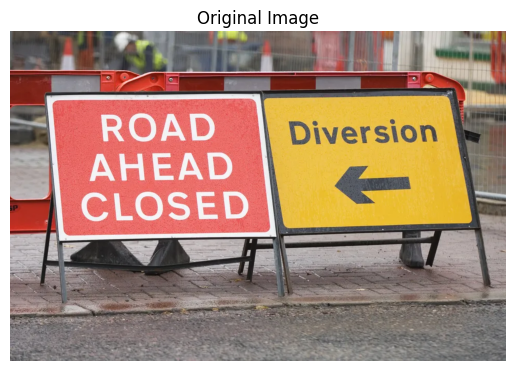

Prompts: ['<OCR>']
[{'<OCR>': 'ROADDiversionAHEADCLOSED'}] 

Prompts: ['<OCR_WITH_REGION>']


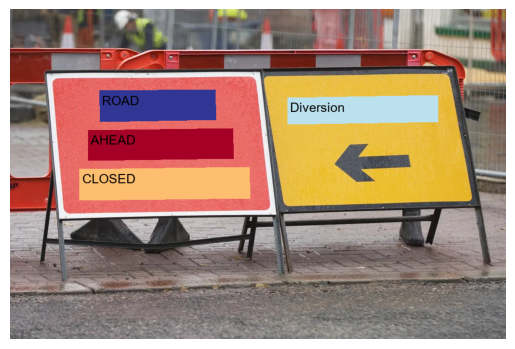

In [ ]:
# base image
img_path = os.path.join(data_path, "base_ocr.jpg")
img = read_image(img_path)
display_image(img, "Original Image")

task_input = "<OCR>"
text_inputs = []
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
print(results, "\n")

task = "<OCR_WITH_REGION>" # returns text with bounding boxes
text_inputs = []
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"polygons": [box for result in results for box in result[task]["quad_boxes"]], "labels": [label.replace("</s>", "").replace("<s>", "") for result in results for label in result[task]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25)

#### Segmentation
Label each pixel of a classs in an image. Note: one object segmented for each image, a quick fix for this below.

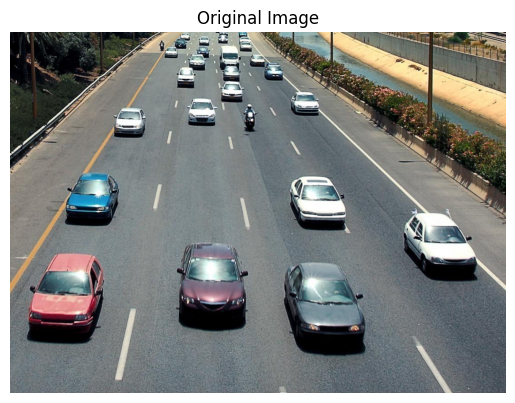

Prompts: ['<REFERRING_EXPRESSION_SEGMENTATION>cars']


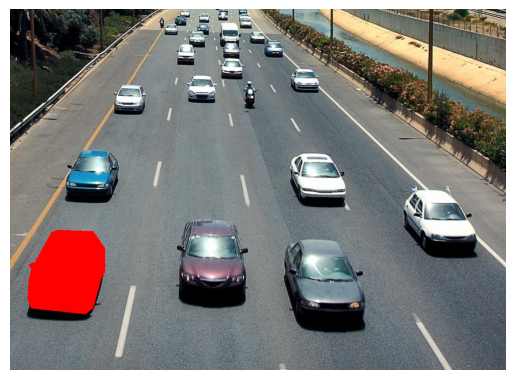

In [ ]:
# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

task_input = "<REFERRING_EXPRESSION_SEGMENTATION>" # returns text with bounding boxes
text_inputs = ["cars"]
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"polygons": [box[task]['polygons'][0][0] for box in results], "labels": [box[task]['labels'] for box in results]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25, label_bb=False, color_bb=False)

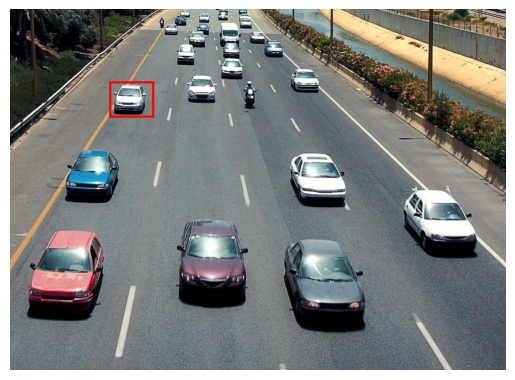

In [ ]:
# we can also provide a bounding box to the model to get the segmentation of the object in the bounding box
# Use this function to decide the normalised bounding box on the image

def draw_normalized_bounding_boxes(image, normalised_boxes, size_bb=5, color="red"):
    """
    Draw bounding boxes on an image using normalized coordinates.
    
    Args:
        image (PIL.Image): The image to draw on.
        bboxes (list): List of bounding boxes in normalized coordinates [x1, y1, x2, y2].
        size_bb (int): Width of the bounding box lines.
        color (str): Color of the bounding boxes.
    """
    # Convert normalized coordinates to absolute pixel values
    width, height = image.size
    absolute_bboxes = [(x1 * width, y1 * height, x2 * width, y2 * height) for x1, y1, x2, y2 in normalised_boxes]
    
    # Draw bounding boxes on the image
    modified_image = image.copy()
    draw = ImageDraw.Draw(modified_image)
    for box in absolute_bboxes:
        draw.rectangle(box, outline=color, width=size_bb)
    
    # Display the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(modified_image)
    plt.axis('off')
    plt.show()
    
normalized_bboxes = [ # select one region for now
    [0.2, 0.2, 0.29, 0.3]
]

draw_normalized_bounding_boxes(img, normalized_bboxes, size_bb=5, color="red")

Prompts: ['<REGION_TO_SEGMENTATION><loc_200><loc_200><loc_290><loc_300>']


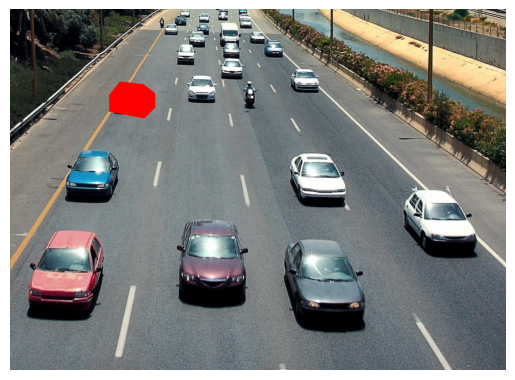

In [ ]:
# # <REGION_TO_SEGMENTATION>
florance_bbox = "".join([f"<loc_{int(min(i,1)*1000)}>" for bbox in normalized_bboxes for i in bbox]) # format as so: '<loc_335><loc_412><loc_653><loc_832>' - 0.653 is equal to loc_693 as florance cordinates are between 0-999

task_input = "<REGION_TO_SEGMENTATION>" # returns text with bounding boxes
text_inputs = [florance_bbox] # add the bounding box to the text inputs
results = inference_Florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)
combined_results = {"polygons": [box[task_input]['polygons'][0][0] for box in results], "labels": [box[task_input]['labels'] for box in results]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25, label_bb=False, color_bb=False)

### Object Detection + Segmentaion to label all instances.

Unfortunately, the Florance model does not support segmentation for multiple objects in the same image, and even if it did we would quickly come up against the maximum token generation for the model: 1024. This is a limitation. However, there is an easy way to get around this, demonstrated below.

We will combine OD and segmentation below, or you can manually label each car yourself using the above function so Florance can segment it.

In [ ]:
# Com